In [1]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import export_text
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [3]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/sy/work/common/common.py'>

In [4]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [5]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"
# project_name = "tii-ssrc"
# project_name = "cirrhosis"
# project_name = "botnet"
# project_name = "ctu13"
project_name = "heart"

In [6]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
elif project_name == "mba":
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()
elif project_name == "tii-ssrc":
    %run datasets/tii-ssrc.ipynb
    all_df, main_labels, config = get_processed_tii_ssrc_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "botnet":
    %run datasets/botnet.ipynb
    all_df, main_labels, config = get_processed_botnet_df()
elif project_name == "heart":
    %run datasets/ctu13.ipynb
    all_df, main_labels, config = get_processed_ctu13_df()
else:
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()

Normal class:  0    smurf.
dtype: object
TARGET_DICT {0: 'apache2', 1: 'back', 2: 'buffer_overflow', 3: 'ftp_write', 4: 'guess_passwd', 5: 'httptunnel', 6: 'imap', 7: 'ipsweep', 8: 'land', 9: 'loadmodule', 10: 'mailbomb', 11: 'mscan', 12: 'multihop', 13: 'named', 14: 'neptune', 15: 'nmap', 16: 'normal', 17: 'perl', 18: 'phf', 19: 'pod', 20: 'portsweep', 21: 'processtable', 22: 'ps', 23: 'rootkit', 24: 'saint', 25: 'satan', 26: 'sendmail', 27: 'smurf', 28: 'snmpgetattack', 29: 'snmpguess', 30: 'sqlattack', 31: 'teardrop', 32: 'udpstorm', 33: 'warezmaster', 34: 'worm', 35: 'xlock', 36: 'xsnoop', 37: 'xterm'}
NORMAL_TARGET 16
main_labels ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate

In [7]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
all_df.shape

(311029, 118)

In [9]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [10]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [11]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(248823, 117) (62206, 117) (248823,) (62206,)


In [12]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack
147391,0,226,3861,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16
107622,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
53448,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27
3099,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27
208489,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27


In [13]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [14]:
X_test_scaled_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
220755,-0.045752,-0.005491,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
158047,-0.045752,-0.012740,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25478,-0.045752,-0.005491,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99780,-0.045752,-0.012445,-0.043135,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
71382,-0.045752,-0.005491,-0.045711,0,-0.019027,-0.005129,-0.045106,-0.046479,0,-0.005387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 3  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    # common.get_dataset_for_label(label, name, target_index, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {27: 164091, 16: 60593, 14: 58001, 28: 7741, 10: 5000, 4: 4367, 29: 2406, 25: 1633, 33: 1602, 1: 1098, 11: 1053, 0: 794, 21: 759, 24: 736, 20: 354, 7: 306, 5: 158, 19: 87, 15: 84, 2: 22, 12: 18, 13: 17, 26: 17, 22: 16, 23: 13, 37: 13, 31: 12, 35: 9, 8: 9, 36: 4, 3: 3, 9: 2, 17: 2, 32: 2, 34: 2, 18: 2, 30: 2, 6: 1}
apache2.csv created with 3176 rows. (2382 benign and 794 abnormal rows)
back.csv created with 4392 rows. (3294 benign and 1098 abnormal rows)
buffer_overflow.csv created with 88 rows. (66 benign and 22 abnormal rows)
ftp_write.csv created with 53 rows. (50 benign and 3 abnormal rows)
guess_passwd.csv created with 17468 rows. (13101 benign and 4367 abnormal rows)
httptunnel.csv created with 632 rows. (474 benign and 158 abnormal rows)
imap.csv created with 51 rows. (50 benign and 1 abnormal rows)
ipsweep.csv created with 1224 rows. (918 benign and 306 abnormal rows)
land.csv created with 59 rows. (50 benign and 9 abnormal rows)
loadmodule.csv created with 52

In [17]:
len(main_labels)

118

csv_files ['named.csv', 'snmpgetattack.csv', 'ipsweep.csv', 'httptunnel.csv', 'sendmail.csv', 'guess_passwd.csv', 'satan.csv', 'ps.csv', 'ftp_write.csv', 'xlock.csv', 'udpstorm.csv', 'teardrop.csv', 'phf.csv', 'pod.csv', 'perl.csv', 'nmap.csv', 'portsweep.csv', 'saint.csv', 'rootkit.csv', 'warezmaster.csv', 'xsnoop.csv', 'sqlattack.csv', 'processtable.csv', 'snmpguess.csv', 'mailbomb.csv', 'imap.csv', 'neptune.csv', 'xterm.csv', 'mscan.csv', 'buffer_overflow.csv', 'loadmodule.csv', 'worm.csv', 'multihop.csv', 'back.csv', 'apache2.csv', 'land.csv', 'smurf.csv']
Processing CSV file: named.csv
named importance list:
named 
                     importance
Features                      
src_bytes             0.085127
dst_bytes             0.065110
duration              0.063298
logged_in             0.014133
count                 0.012397
is_host_login         0.010565
hot                   0.003957
is_guest_login        0.001446
urgent                0.000000
num_failed_logins     0.000000

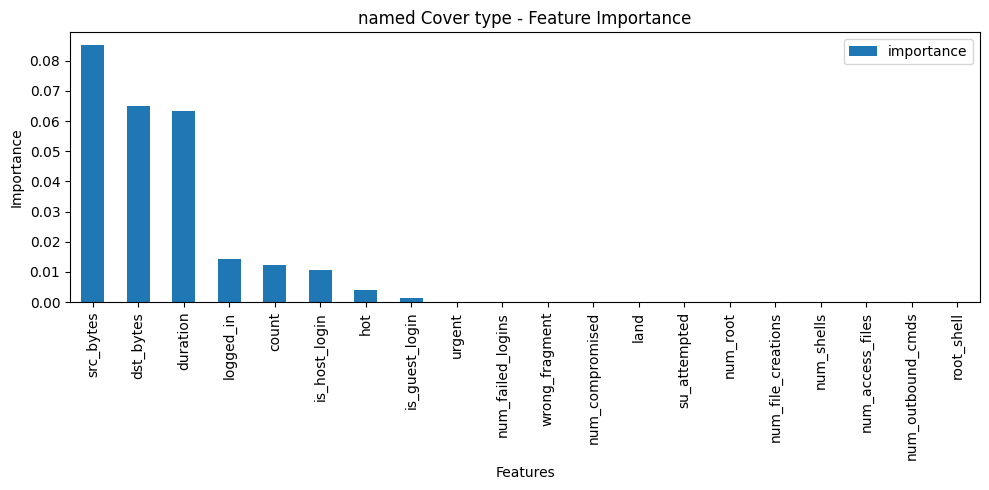

-----------------------------------------------------------------------------------------------




Processing CSV file: snmpgetattack.csv
snmpgetattack importance list:
snmpgetattack 
                       importance
Features                        
dst_bytes           2.666913e-01
src_bytes           8.343365e-02
count               4.208638e-02
logged_in           2.644931e-02
duration            6.056815e-04
is_guest_login      4.501429e-05
wrong_fragment      3.703477e-05
hot                 2.078805e-05
num_compromised     8.465054e-06
num_root            7.961845e-06
num_file_creations  3.631026e-06
is_host_login       1.057877e-06
num_failed_logins   2.061859e-07
num_access_files    2.337027e-08
urgent              0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
root_shell          0.000000e+00 



snmpgetattack=["dst_bytes","src_bytes","count","logged_in","duration"]


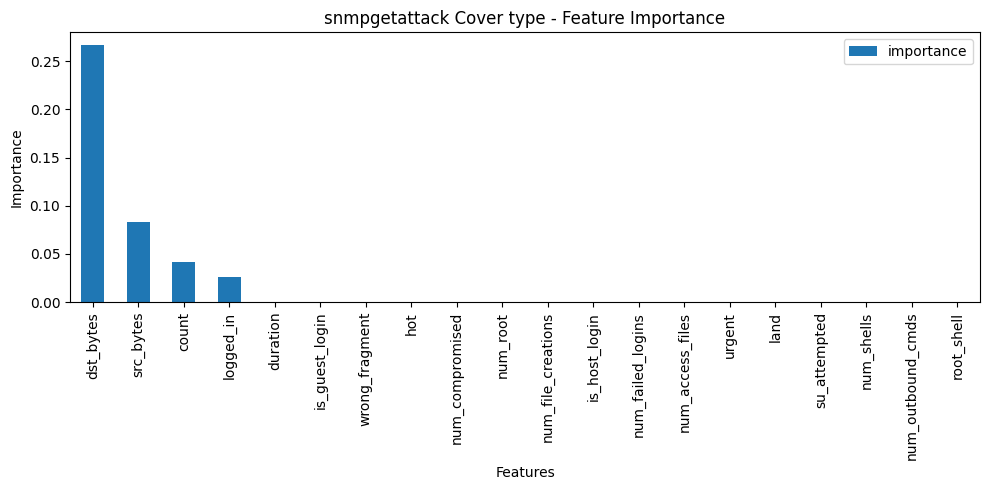

-----------------------------------------------------------------------------------------------




Processing CSV file: ipsweep.csv
ipsweep importance list:
ipsweep 
                     importance
Features                      
src_bytes             0.111423
dst_bytes             0.064431
count                 0.047471
logged_in             0.015494
duration              0.000506
is_guest_login        0.000123
hot                   0.000100
num_access_files      0.000038
urgent                0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
root_shell            0.000000 



ipsweep=["src_bytes","dst_bytes","count","logged_in","duration"]


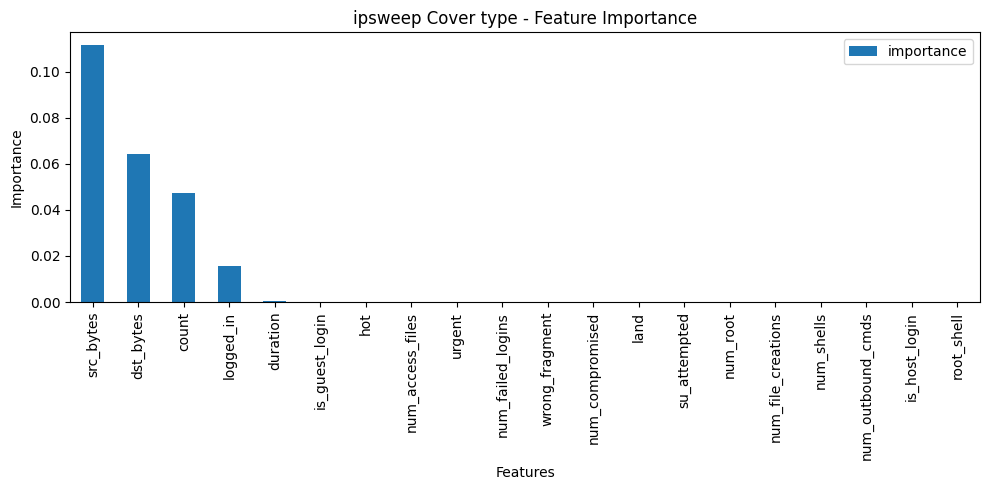

-----------------------------------------------------------------------------------------------




Processing CSV file: httptunnel.csv
httptunnel importance list:
httptunnel 
                       importance
Features                        
src_bytes           4.428992e-02
dst_bytes           4.403284e-02
count               1.660688e-02
logged_in           1.241818e-02
duration            6.448496e-03
hot                 1.890865e-03
su_attempted        7.162117e-04
root_shell          6.737375e-04
num_shells          5.121170e-04
num_compromised     4.568548e-04
is_guest_login      1.362227e-04
num_root            1.261663e-04
num_file_creations  2.757435e-07
wrong_fragment      7.665083e-10
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
num_access_files    0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00 



httptunnel=["src_bytes","dst_bytes","count","logged_in","duration"]


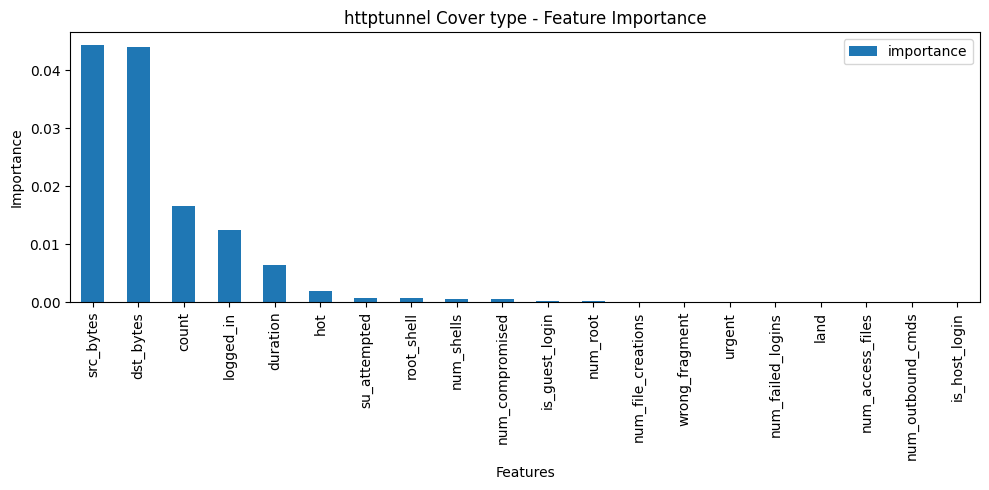

-----------------------------------------------------------------------------------------------




Processing CSV file: sendmail.csv
sendmail importance list:
sendmail 
                     importance
Features                      
src_bytes             0.087951
duration              0.078336
num_root              0.044593
count                 0.042759
dst_bytes             0.038587
num_access_files      0.038189
root_shell            0.021480
logged_in             0.011319
num_failed_logins     0.007520
wrong_fragment        0.000000
urgent                0.000000
hot                   0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_file_creations    0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



sendmail=["src_bytes","duration","num_root","count","dst_bytes"]


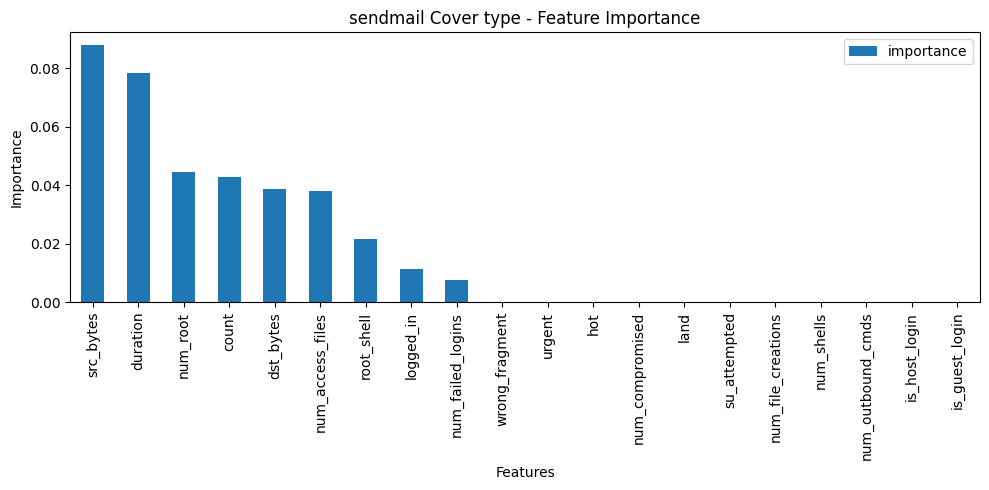

-----------------------------------------------------------------------------------------------




Processing CSV file: guess_passwd.csv
guess_passwd importance list:
guess_passwd 
                     importance
Features                      
duration              0.154455
src_bytes             0.101578
dst_bytes             0.082484
count                 0.057420
num_failed_logins     0.038612
logged_in             0.028179
is_guest_login        0.003952
hot                   0.000306
num_compromised       0.000070
root_shell            0.000025
num_file_creations    0.000022
num_access_files      0.000011
num_root              0.000010
is_host_login         0.000008
su_attempted          0.000002
wrong_fragment        0.000001
urgent                0.000000
land                  0.000000
num_shells            0.000000
num_outbound_cmds     0.000000 



guess_passwd=["duration","src_bytes","dst_bytes","count","num_failed_logins"]


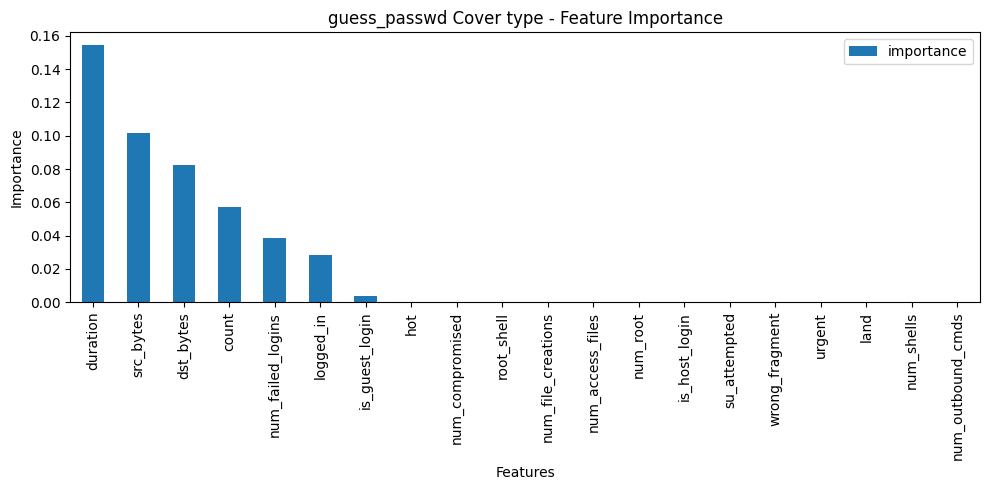

-----------------------------------------------------------------------------------------------




Processing CSV file: satan.csv
satan importance list:
satan 
                       importance
Features                        
count               8.000855e-02
src_bytes           7.843970e-02
dst_bytes           4.598289e-02
logged_in           1.383046e-02
duration            3.093922e-04
num_file_creations  2.995515e-05
hot                 7.641851e-06
wrong_fragment      8.754532e-09
num_access_files    2.641877e-09
num_compromised     3.788994e-13
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_root            0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00
is_guest_login      0.000000e+00
root_shell          0.000000e+00 



satan=["count","src_bytes","dst_bytes","logged_in","duration"]


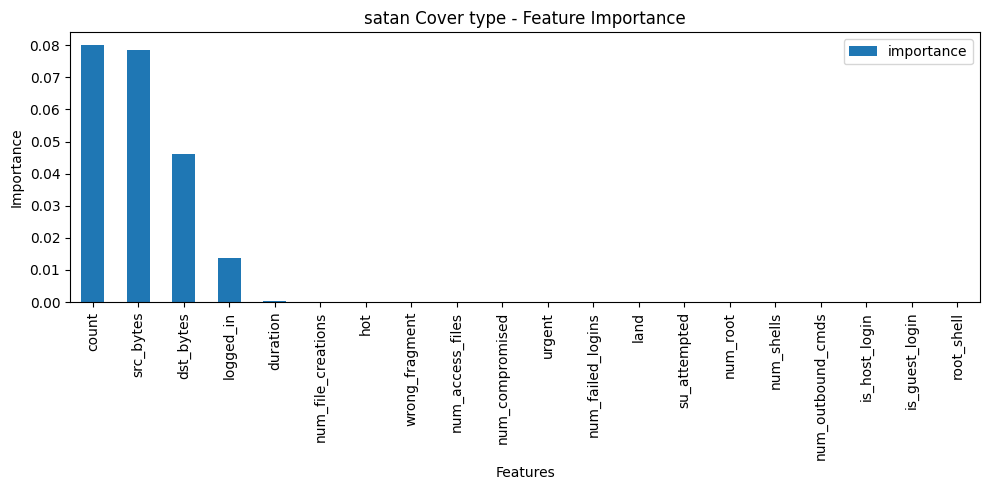

-----------------------------------------------------------------------------------------------




Processing CSV file: ps.csv
ps importance list:
ps 
                     importance
Features                      
duration              0.145712
num_file_creations    0.086781
hot                   0.061371
src_bytes             0.059502
count                 0.033945
dst_bytes             0.031518
logged_in             0.015378
num_compromised       0.009347
num_shells            0.007640
is_host_login         0.002493
num_root              0.002098
num_access_files      0.001670
num_failed_logins     0.001133
root_shell            0.000051
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
su_attempted          0.000000
num_outbound_cmds     0.000000
is_guest_login        0.000000 



ps=["duration","num_file_creations","hot","src_bytes","count"]


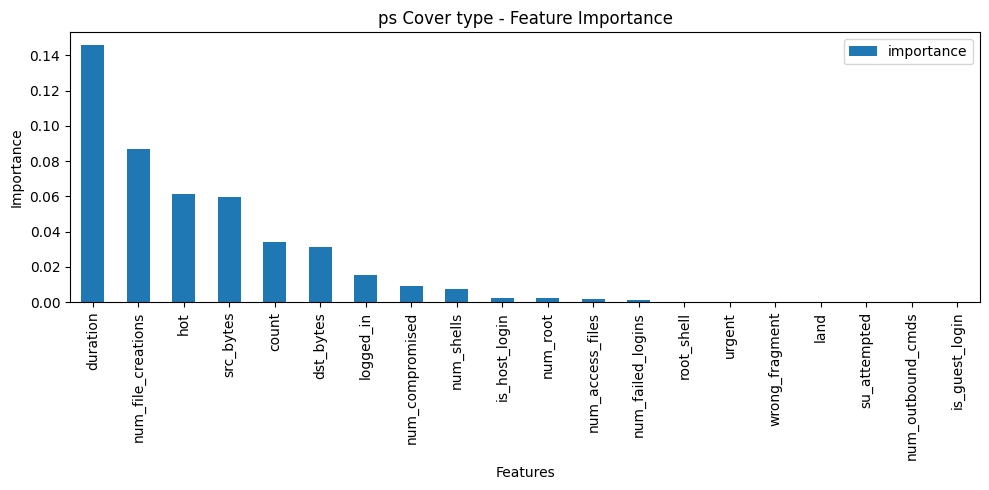

-----------------------------------------------------------------------------------------------




Processing CSV file: ftp_write.csv
ftp_write importance list:
ftp_write 
                     importance
Features                      
src_bytes             0.090393
duration              0.080178
urgent                0.031035
dst_bytes             0.029372
num_access_files      0.027457
is_guest_login        0.025456
num_file_creations    0.024152
hot                   0.021461
count                 0.011116
logged_in             0.008785
num_compromised       0.000000
su_attempted          0.000000
num_root              0.000000
num_failed_logins     0.000000
num_shells            0.000000
wrong_fragment        0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
land                  0.000000
root_shell            0.000000 



ftp_write=["src_bytes","duration","urgent","dst_bytes","num_access_files"]


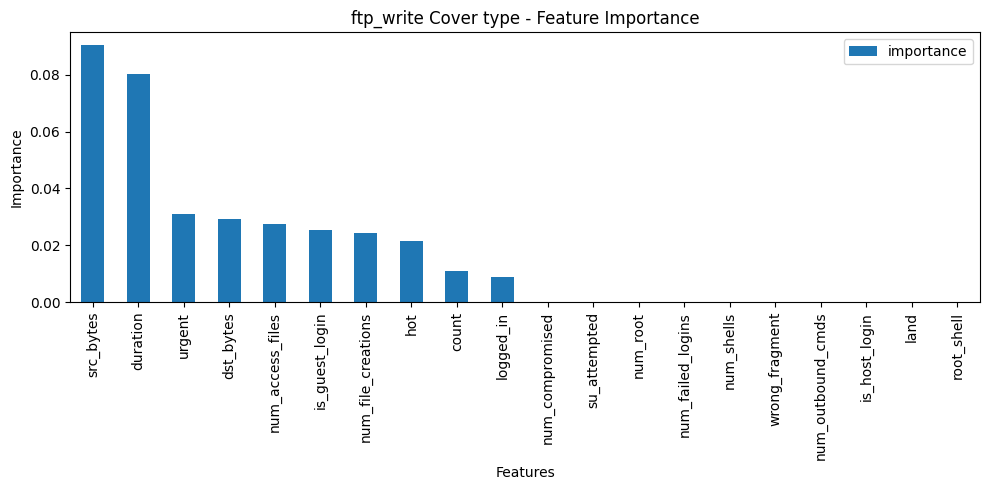

-----------------------------------------------------------------------------------------------




Processing CSV file: xlock.csv
xlock importance list:
xlock 
                     importance
Features                      
duration              0.179705
src_bytes             0.105894
dst_bytes             0.070082
count                 0.035552
num_compromised       0.007955
num_access_files      0.007534
num_failed_logins     0.006944
logged_in             0.004165
num_root              0.002271
wrong_fragment        0.000000
urgent                0.000000
hot                   0.000000
land                  0.000000
su_attempted          0.000000
num_file_creations    0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



xlock=["duration","src_bytes","dst_bytes","count","num_compromised"]


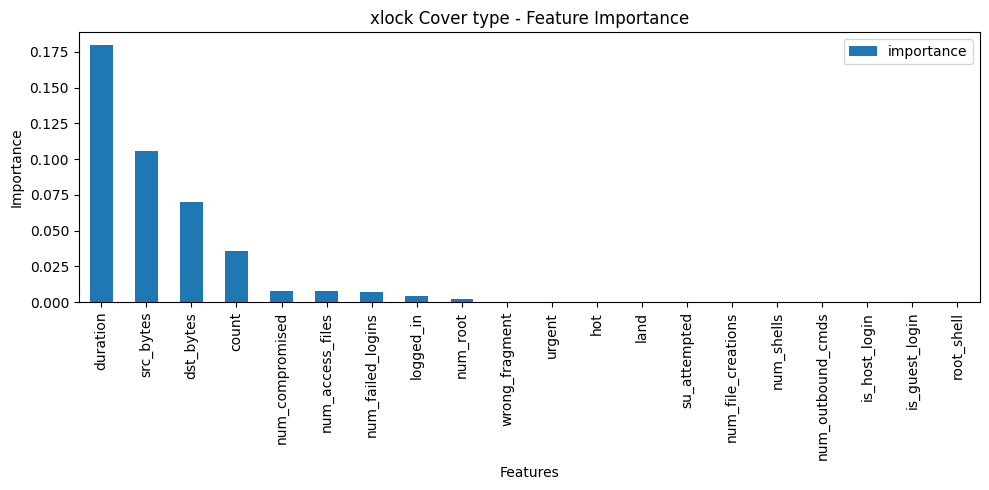

-----------------------------------------------------------------------------------------------




Processing CSV file: udpstorm.csv
udpstorm importance list:
udpstorm 
                     importance
Features                      
src_bytes             0.166432
dst_bytes             0.042664
count                 0.020807
logged_in             0.016462
duration              0.000069
num_access_files      0.000055
hot                   0.000013
is_guest_login        0.000009
urgent                0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
root_shell            0.000000 



udpstorm=["src_bytes","dst_bytes","count","logged_in","duration"]


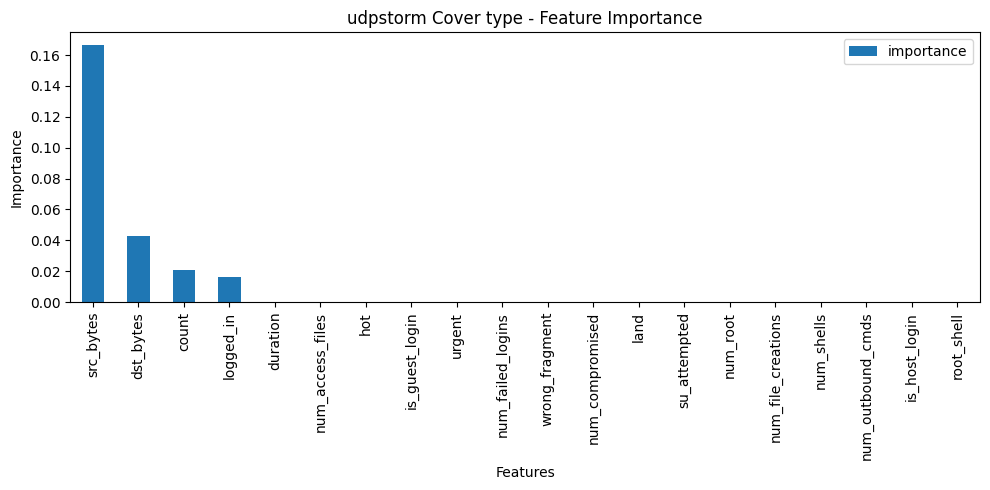

-----------------------------------------------------------------------------------------------




Processing CSV file: teardrop.csv
teardrop importance list:
teardrop 
                     importance
Features                      
wrong_fragment        0.164188
src_bytes             0.153726
dst_bytes             0.044562
count                 0.044452
logged_in             0.010295
duration              0.000308
hot                   0.000000
num_failed_logins     0.000000
urgent                0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



teardrop=["wrong_fragment","src_bytes","dst_bytes","count","logged_in"]


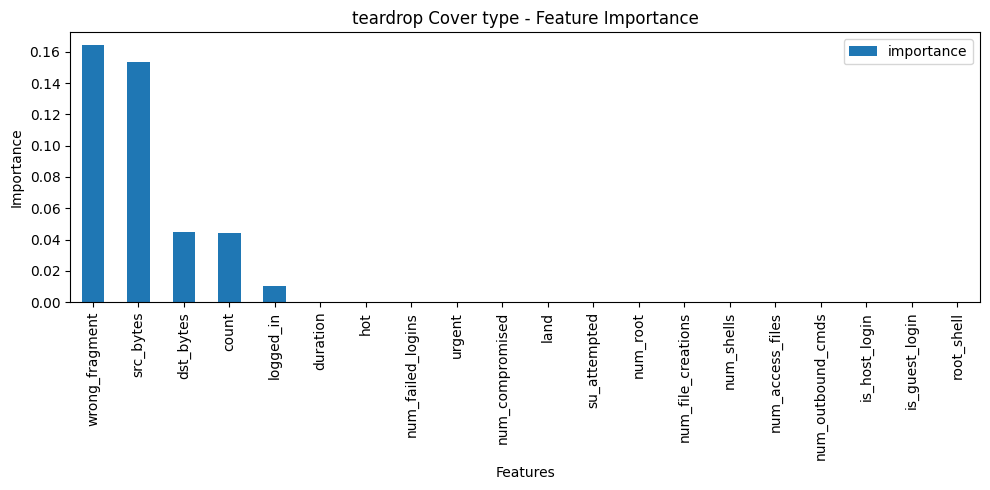

-----------------------------------------------------------------------------------------------




Processing CSV file: phf.csv
phf importance list:
phf 
                     importance
Features                      
src_bytes             0.113888
hot                   0.090820
root_shell            0.063062
num_access_files      0.059533
count                 0.033528
dst_bytes             0.030984
logged_in             0.015433
duration              0.000041
urgent                0.000000
wrong_fragment        0.000000
num_failed_logins     0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



phf=["src_bytes","hot","root_shell","num_access_files","count"]


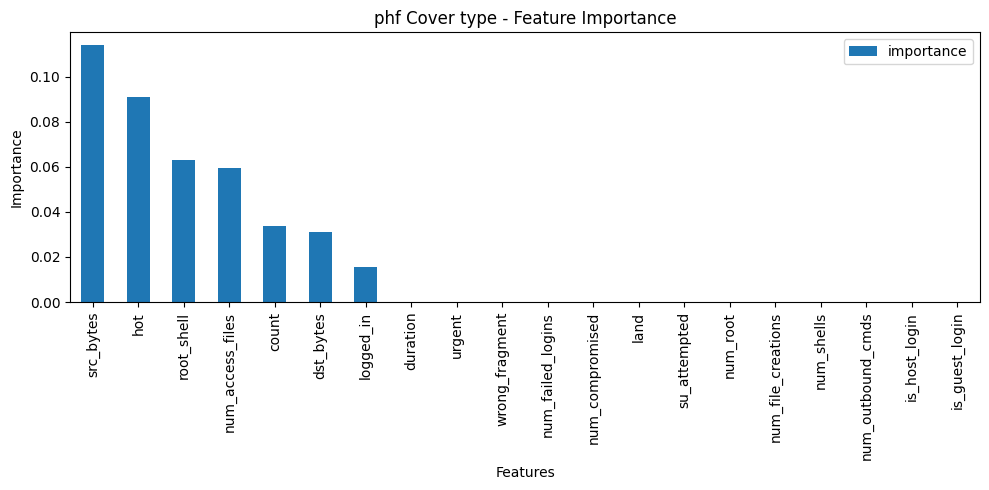

-----------------------------------------------------------------------------------------------




Processing CSV file: pod.csv
pod importance list:
pod 
                     importance
Features                      
wrong_fragment        0.093353
src_bytes             0.087729
dst_bytes             0.058148
count                 0.027261
logged_in             0.027047
num_file_creations    0.000319
duration              0.000110
is_guest_login        0.000039
num_access_files      0.000008
num_failed_logins     0.000000
hot                   0.000000
num_compromised       0.000000
urgent                0.000000
su_attempted          0.000000
num_root              0.000000
land                  0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
root_shell            0.000000 



pod=["wrong_fragment","src_bytes","dst_bytes","count","logged_in"]


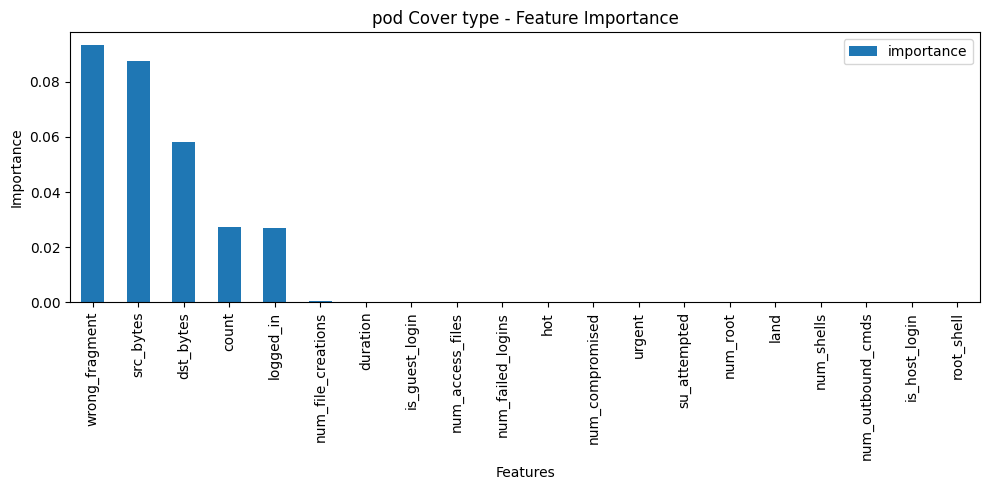

-----------------------------------------------------------------------------------------------




Processing CSV file: perl.csv
perl importance list:
perl 
                     importance
Features                      
duration              0.150627
num_shells            0.135459
num_root              0.094870
num_file_creations    0.052494
root_shell            0.030406
count                 0.011922
src_bytes             0.008327
dst_bytes             0.005103
logged_in             0.000105
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
num_compromised       0.000000
su_attempted          0.000000
wrong_fragment        0.000000
land                  0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



perl=["duration","num_shells","num_root","num_file_creations","root_shell"]


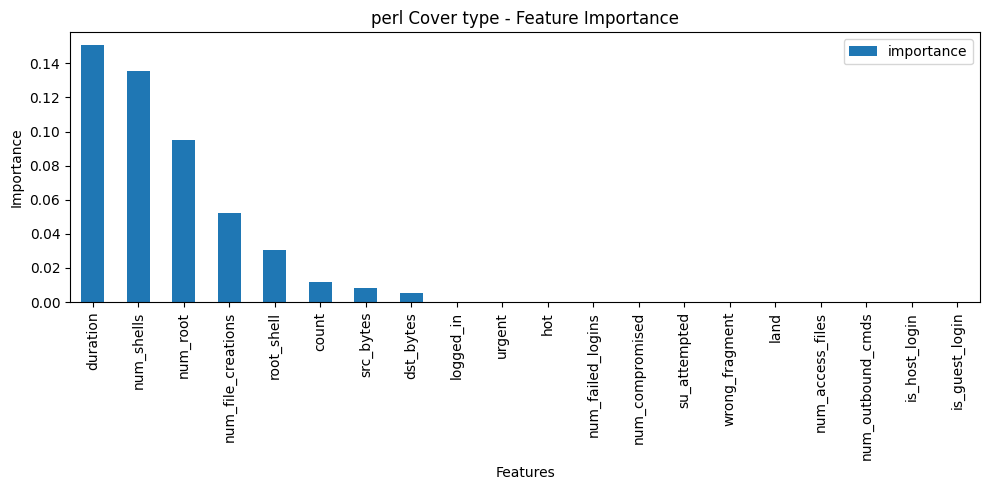

-----------------------------------------------------------------------------------------------




Processing CSV file: nmap.csv
nmap importance list:
nmap 
                     importance
Features                      
dst_bytes             0.062965
src_bytes             0.020186
logged_in             0.019565
count                 0.015336
duration              0.000999
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



nmap=["dst_bytes","src_bytes","logged_in","count","duration"]


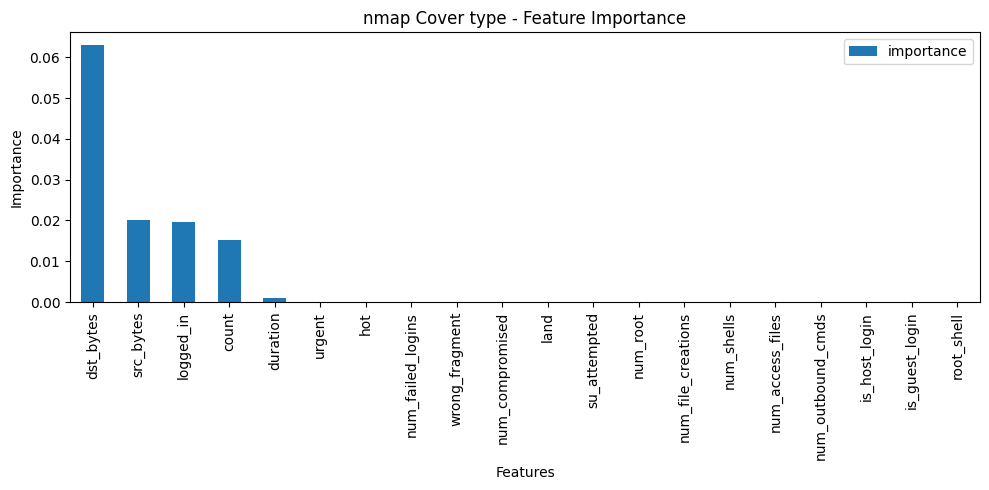

-----------------------------------------------------------------------------------------------




Processing CSV file: portsweep.csv
portsweep importance list:
portsweep 
                     importance
Features                      
src_bytes             0.111364
dst_bytes             0.042629
logged_in             0.009846
count                 0.003096
duration              0.000079
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



portsweep=["src_bytes","dst_bytes","logged_in","count","duration"]


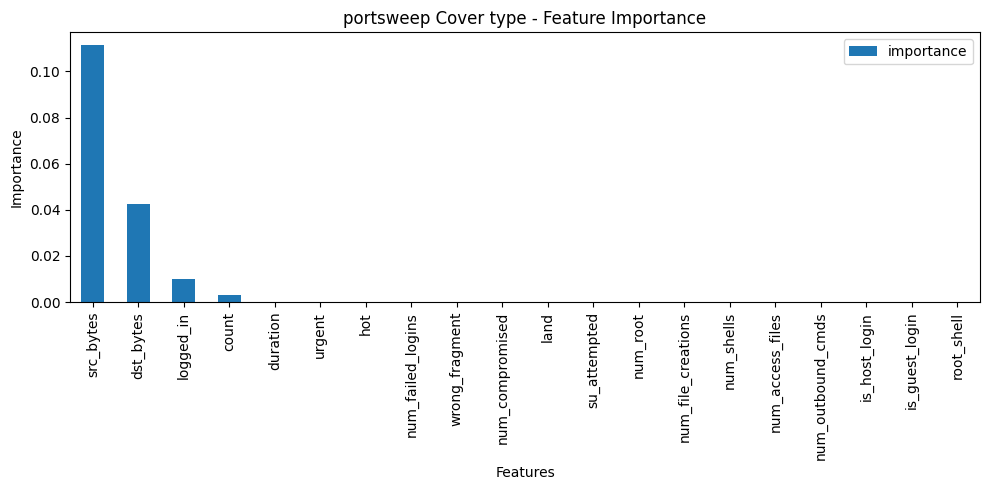

-----------------------------------------------------------------------------------------------




Processing CSV file: saint.csv
saint importance list:
saint 
                     importance
Features                      
src_bytes             0.114104
count                 0.058991
dst_bytes             0.040607
logged_in             0.004568
duration              0.000389
wrong_fragment        0.000054
is_guest_login        0.000017
hot                   0.000012
num_access_files      0.000002
urgent                0.000000
num_failed_logins     0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
root_shell            0.000000 



saint=["src_bytes","count","dst_bytes","logged_in","duration"]


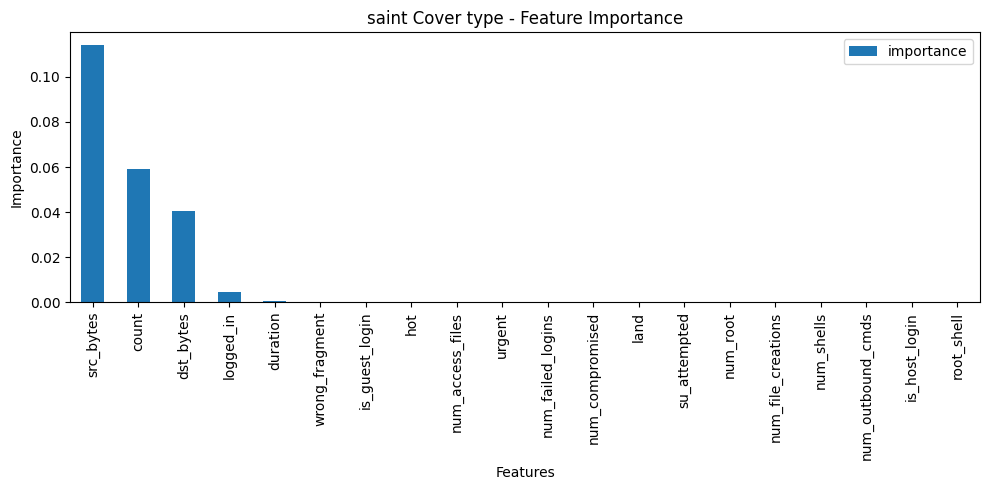

-----------------------------------------------------------------------------------------------




Processing CSV file: rootkit.csv
rootkit importance list:
rootkit 
                     importance
Features                      
duration              0.085299
count                 0.057778
hot                   0.041240
src_bytes             0.039026
dst_bytes             0.025498
num_file_creations    0.009339
num_root              0.003922
is_host_login         0.003814
num_shells            0.003800
urgent                0.002630
num_compromised       0.002582
root_shell            0.002140
logged_in             0.001485
land                  0.000000
num_failed_logins     0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
wrong_fragment        0.000000
is_guest_login        0.000000
su_attempted          0.000000 



rootkit=["duration","count","hot","src_bytes","dst_bytes"]


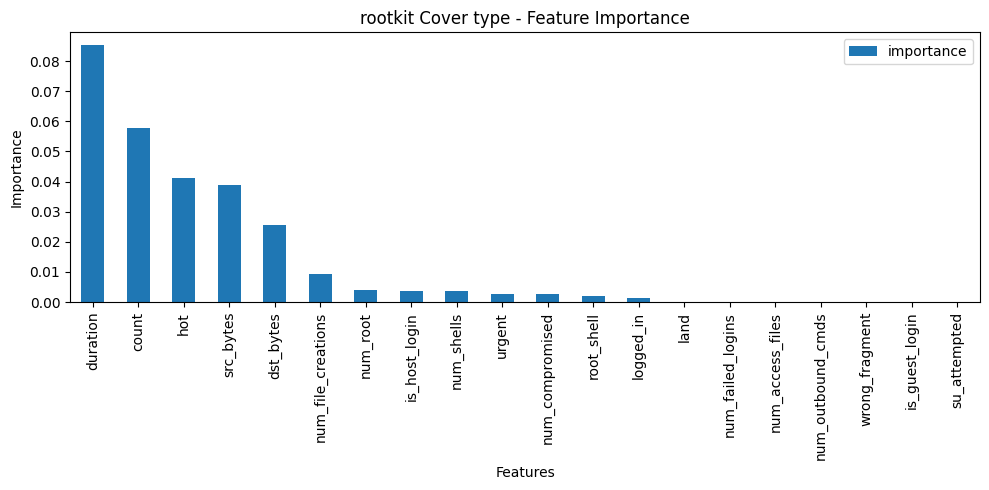

-----------------------------------------------------------------------------------------------




Processing CSV file: warezmaster.csv
warezmaster importance list:
warezmaster 
                     importance
Features                      
duration              0.134985
dst_bytes             0.062547
hot                   0.054357
src_bytes             0.054114
is_guest_login        0.031751
count                 0.027710
logged_in             0.023382
is_host_login         0.000076
num_root              0.000050
wrong_fragment        0.000045
num_compromised       0.000014
num_failed_logins     0.000008
num_access_files      0.000006
num_file_creations    0.000001
urgent                0.000000
su_attempted          0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
land                  0.000000
root_shell            0.000000 



warezmaster=["duration","dst_bytes","hot","src_bytes","is_guest_login"]


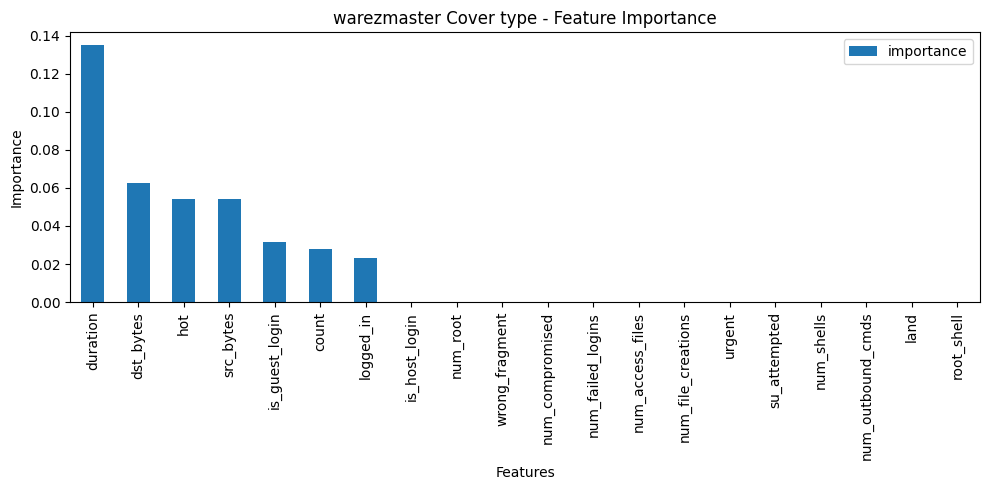

-----------------------------------------------------------------------------------------------




Processing CSV file: xsnoop.csv
xsnoop importance list:
xsnoop 
                     importance
Features                      
dst_bytes             0.077577
duration              0.075116
is_host_login         0.060286
hot                   0.051014
num_root              0.037198
src_bytes             0.036911
root_shell            0.030306
num_file_creations    0.018105
logged_in             0.010811
num_shells            0.008255
num_access_files      0.007047
count                 0.006311
num_failed_logins     0.000000
num_compromised       0.000000
urgent                0.000000
su_attempted          0.000000
wrong_fragment        0.000000
num_outbound_cmds     0.000000
land                  0.000000
is_guest_login        0.000000 



xsnoop=["dst_bytes","duration","is_host_login","hot","num_root"]


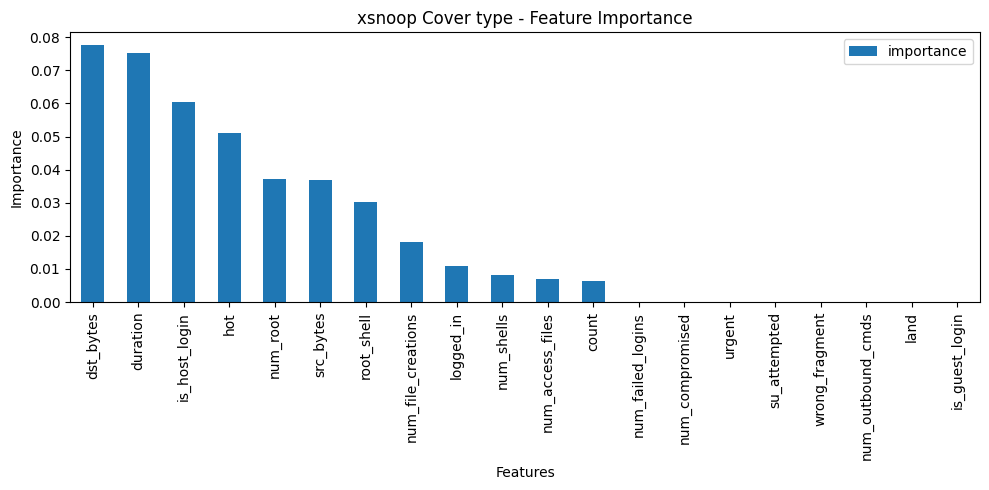

-----------------------------------------------------------------------------------------------




Processing CSV file: sqlattack.csv
sqlattack importance list:
sqlattack 
                     importance
Features                      
urgent                0.102932
num_file_creations    0.101047
root_shell            0.091957
num_access_files      0.090625
num_root              0.077755
dst_bytes             0.072884
hot                   0.068509
duration              0.061213
num_shells            0.054516
src_bytes             0.025065
logged_in             0.018087
count                 0.010994
num_compromised       0.000000
su_attempted          0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
land                  0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



sqlattack=["urgent","num_file_creations","root_shell","num_access_files","num_root"]


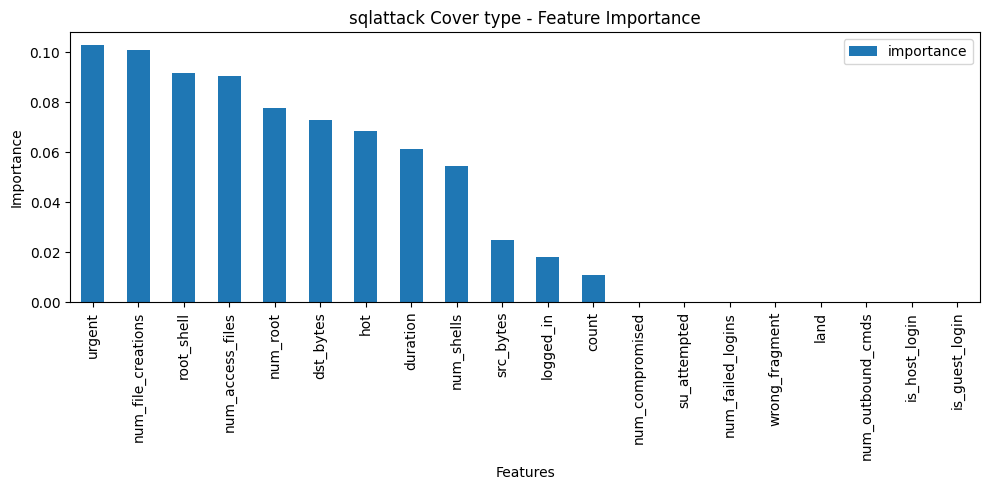

-----------------------------------------------------------------------------------------------




Processing CSV file: processtable.csv
processtable importance list:
processtable 
                       importance
Features                        
src_bytes           1.076971e-01
dst_bytes           6.452526e-02
duration            5.543525e-02
count               2.495071e-02
logged_in           6.672302e-03
num_compromised     6.883172e-05
num_file_creations  5.111045e-05
num_root            1.718005e-05
wrong_fragment      1.700342e-05
root_shell          1.602841e-05
num_access_files    1.571301e-06
hot                 1.791731e-08
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00
is_guest_login      0.000000e+00 



processtable=["src_bytes","dst_bytes","duration","count","logged_in"]


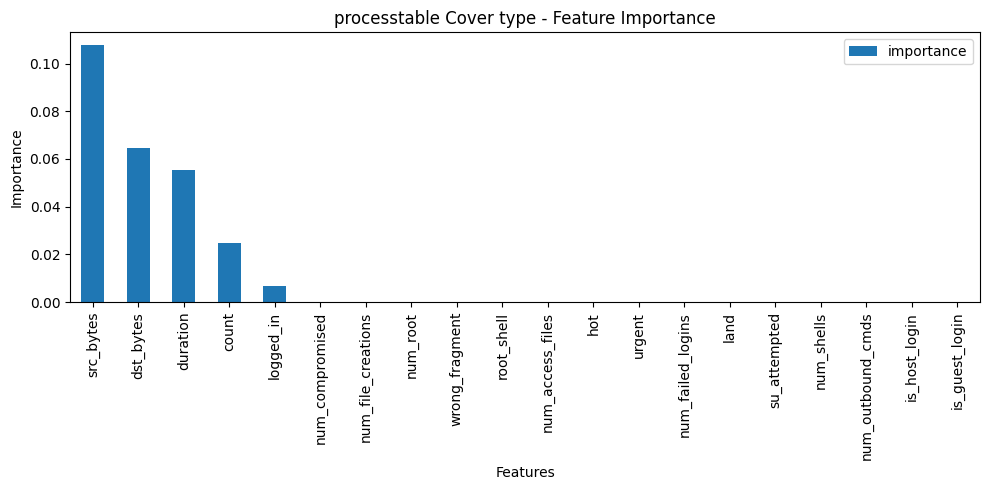

-----------------------------------------------------------------------------------------------




Processing CSV file: snmpguess.csv
snmpguess importance list:
snmpguess 
                       importance
Features                        
src_bytes           2.564917e-01
dst_bytes           1.709802e-01
count               6.708599e-02
logged_in           2.741318e-02
duration            5.265980e-04
wrong_fragment      7.382293e-05
hot                 2.619079e-05
is_guest_login      7.168860e-06
num_access_files    1.108634e-09
num_compromised     1.486008e-10
num_file_creations  5.057819e-13
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_root            0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00
root_shell          0.000000e+00 



snmpguess=["src_bytes","dst_bytes","count","logged_in","duration"]


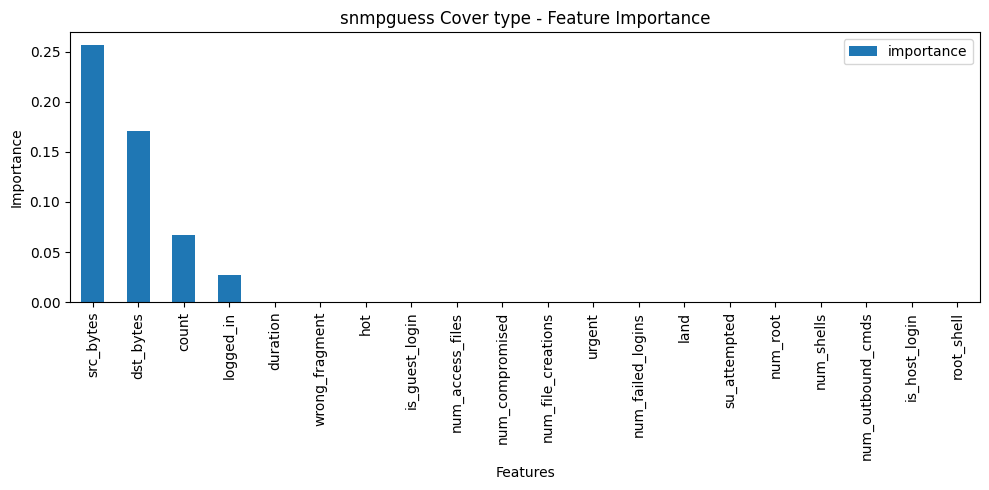

-----------------------------------------------------------------------------------------------




Processing CSV file: mailbomb.csv
mailbomb importance list:
mailbomb 
                       importance
Features                        
src_bytes           1.623573e-01
duration            1.310116e-01
dst_bytes           6.748509e-02
count               2.023532e-02
logged_in           1.863745e-02
hot                 1.477260e-04
num_access_files    7.622140e-05
is_guest_login      5.442362e-05
num_file_creations  1.274352e-05
root_shell          5.183387e-06
num_compromised     2.004653e-06
num_root            3.989523e-10
wrong_fragment      0.000000e+00
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00 



mailbomb=["src_bytes","duration","dst_bytes","count","logged_in"]


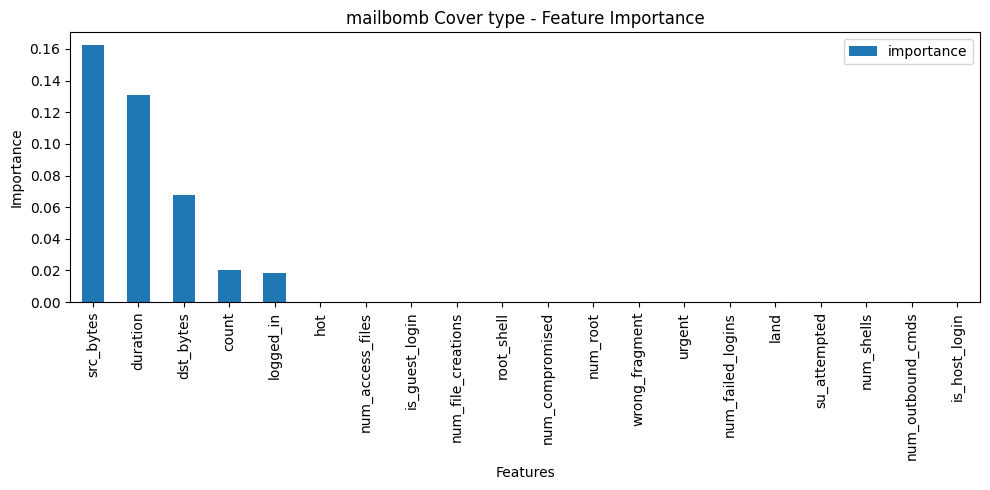

-----------------------------------------------------------------------------------------------




Processing CSV file: imap.csv
imap importance list:
imap 
                     importance
Features                      
duration              0.110960
src_bytes             0.071512
logged_in             0.008975
count                 0.006946
dst_bytes             0.001879
wrong_fragment        0.000000
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
land                  0.000000
num_compromised       0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



imap=["duration","src_bytes","logged_in","count","dst_bytes"]


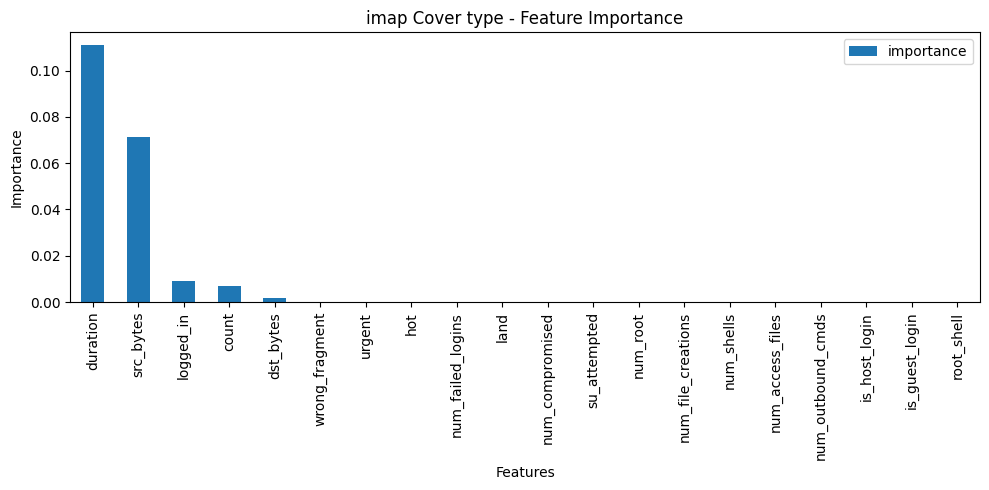

-----------------------------------------------------------------------------------------------




Processing CSV file: neptune.csv
neptune importance list:
neptune 
                       importance
Features                        
count               9.158795e-02
src_bytes           8.966635e-02
dst_bytes           4.023120e-02
logged_in           2.194338e-02
duration            5.018236e-04
is_guest_login      6.391435e-06
num_compromised     9.158664e-07
hot                 6.781624e-07
num_file_creations  6.640513e-07
wrong_fragment      2.720354e-09
num_access_files    6.236741e-10
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_root            0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00
root_shell          0.000000e+00 



neptune=["count","src_bytes","dst_bytes","logged_in","duration"]


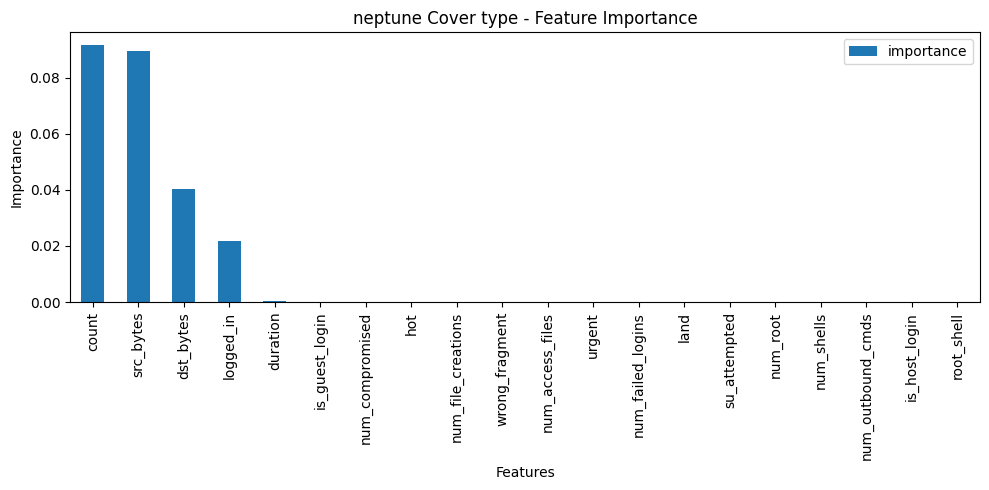

-----------------------------------------------------------------------------------------------




Processing CSV file: xterm.csv
xterm importance list:
xterm 
                     importance
Features                      
src_bytes             0.095989
duration              0.095725
count                 0.063399
hot                   0.062653
urgent                0.034377
num_compromised       0.022633
root_shell            0.019726
num_file_creations    0.018987
num_shells            0.017691
num_root              0.012513
dst_bytes             0.012025
is_host_login         0.010567
num_access_files      0.005381
logged_in             0.004054
num_outbound_cmds     0.000000
is_guest_login        0.000000
land                  0.000000
wrong_fragment        0.000000
num_failed_logins     0.000000
su_attempted          0.000000 



xterm=["src_bytes","duration","count","hot","urgent"]


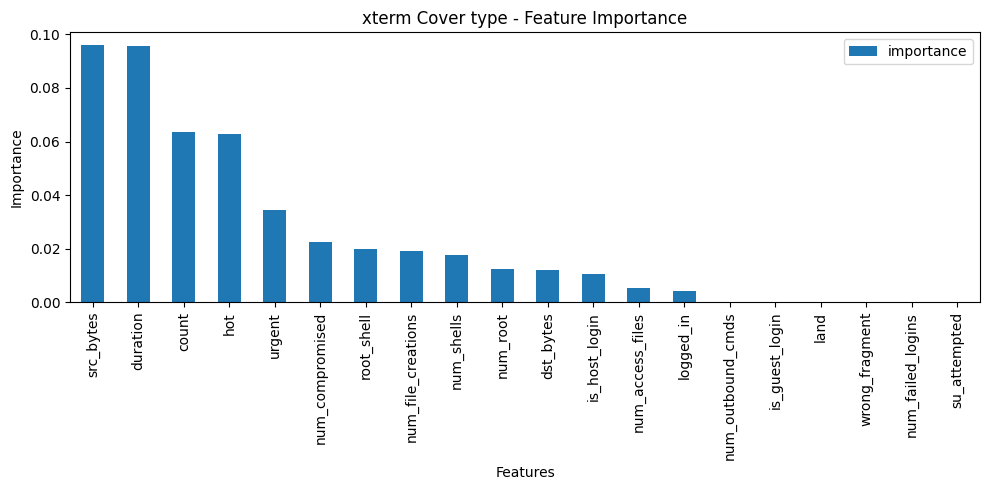

-----------------------------------------------------------------------------------------------




Processing CSV file: mscan.csv
mscan importance list:
mscan 
                     importance
Features                      
src_bytes             0.141971
dst_bytes             0.052510
logged_in             0.015115
count                 0.004940
duration              0.003780
hot                   0.000011
wrong_fragment        0.000007
urgent                0.000000
num_failed_logins     0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



mscan=["src_bytes","dst_bytes","logged_in","count","duration"]


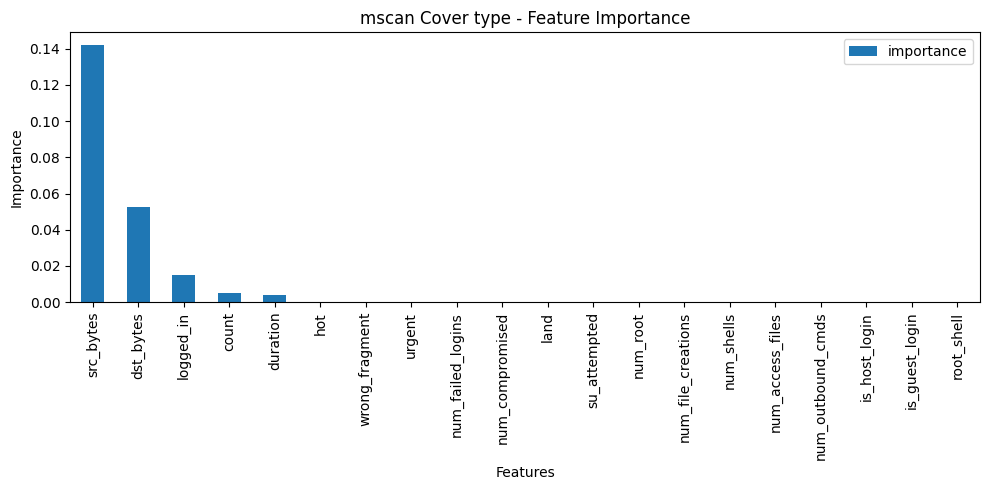

-----------------------------------------------------------------------------------------------




Processing CSV file: buffer_overflow.csv
buffer_overflow importance list:
buffer_overflow 
                     importance
Features                      
duration              0.117269
num_compromised       0.069212
hot                   0.060968
src_bytes             0.057044
num_file_creations    0.050877
root_shell            0.044027
dst_bytes             0.040318
num_root              0.012260
count                 0.011769
logged_in             0.006526
num_access_files      0.000977
num_failed_logins     0.000517
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
su_attempted          0.000000
num_shells            0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



buffer_overflow=["duration","num_compromised","hot","src_bytes","num_file_creations"]


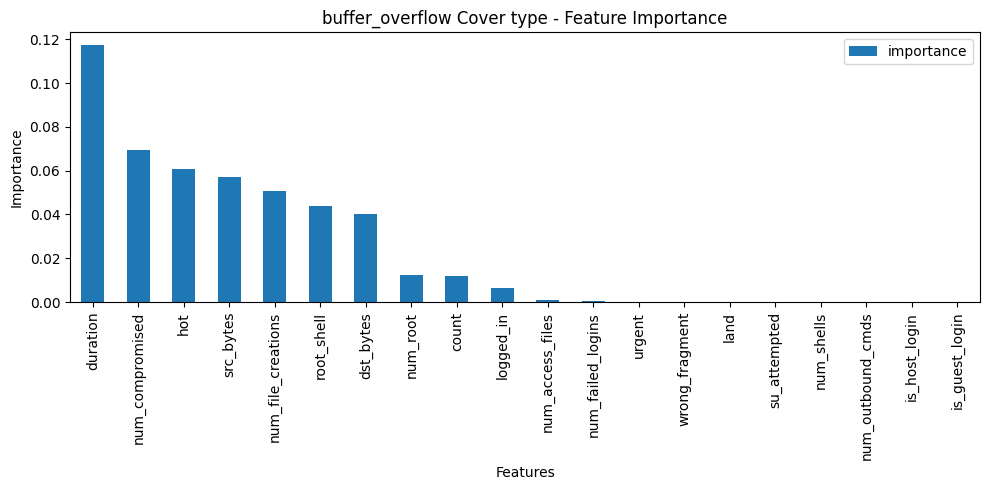

-----------------------------------------------------------------------------------------------




Processing CSV file: loadmodule.csv
loadmodule importance list:
loadmodule 
                     importance
Features                      
num_file_creations    0.135505
num_compromised       0.104429
root_shell            0.082467
hot                   0.078369
num_shells            0.056818
duration              0.050230
src_bytes             0.006648
dst_bytes             0.003951
count                 0.001488
urgent                0.000000
num_failed_logins     0.000000
logged_in             0.000000
wrong_fragment        0.000000
su_attempted          0.000000
num_root              0.000000
land                  0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



loadmodule=["num_file_creations","num_compromised","root_shell","hot","num_shells"]


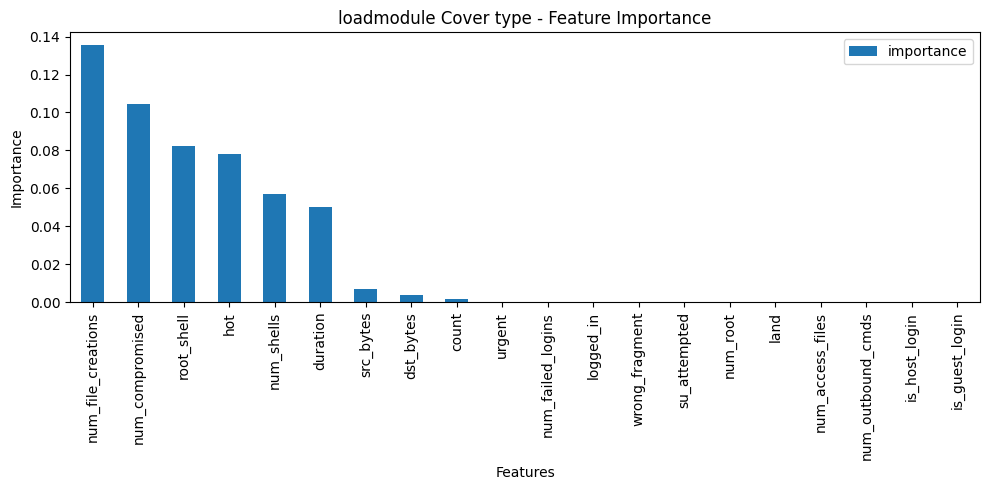

-----------------------------------------------------------------------------------------------




Processing CSV file: worm.csv
worm importance list:
worm 
                     importance
Features                      
src_bytes             0.152225
duration              0.113880
dst_bytes             0.071999
count                 0.029091
logged_in             0.001784
wrong_fragment        0.000035
num_file_creations    0.000026
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



worm=["src_bytes","duration","dst_bytes","count","logged_in"]


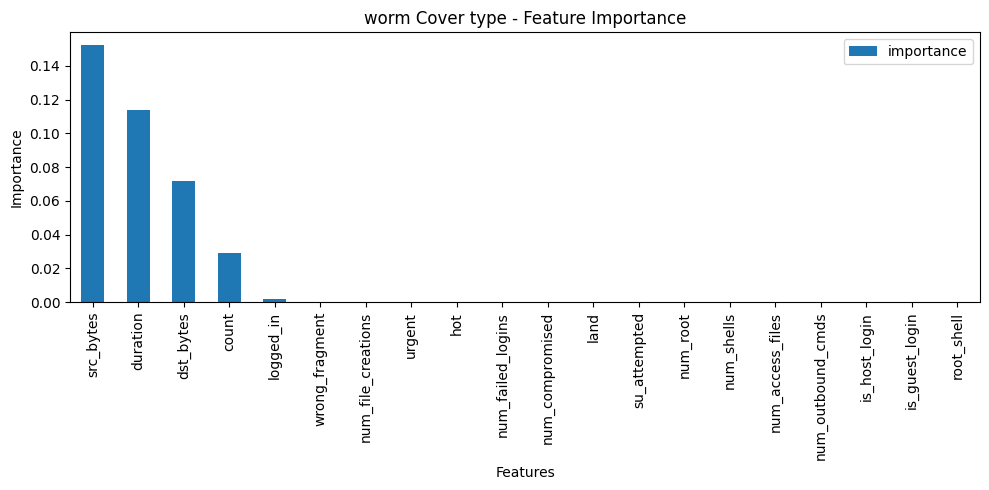

-----------------------------------------------------------------------------------------------




Processing CSV file: multihop.csv
multihop importance list:
multihop 
                     importance
Features                      
src_bytes             0.063796
duration              0.053576
dst_bytes             0.053497
count                 0.022059
hot                   0.020198
num_file_creations    0.015266
is_guest_login        0.014347
is_host_login         0.010334
logged_in             0.009984
num_shells            0.004221
num_compromised       0.003891
num_root              0.001888
num_access_files      0.001680
root_shell            0.001678
wrong_fragment        0.000000
urgent                0.000000
num_failed_logins     0.000000
land                  0.000000
su_attempted          0.000000
num_outbound_cmds     0.000000 



multihop=["src_bytes","duration","dst_bytes","count","hot"]


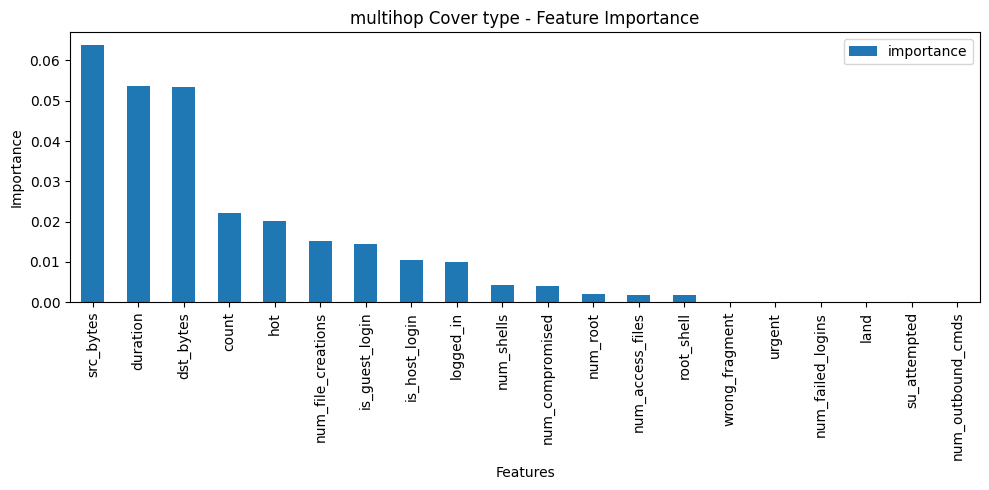

-----------------------------------------------------------------------------------------------




Processing CSV file: back.csv
back importance list:
back 
                       importance
Features                        
num_compromised     2.011894e-01
hot                 1.567694e-01
src_bytes           1.375033e-01
dst_bytes           9.098147e-02
count               1.738351e-02
logged_in           3.821369e-03
duration            8.228577e-04
is_guest_login      1.301583e-04
num_access_files    8.024977e-05
root_shell          1.787555e-05
wrong_fragment      3.922806e-09
num_file_creations  9.314724e-10
num_failed_logins   0.000000e+00
urgent              0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_root            0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00 



back=["num_compromised","hot","src_bytes","dst_bytes","count"]


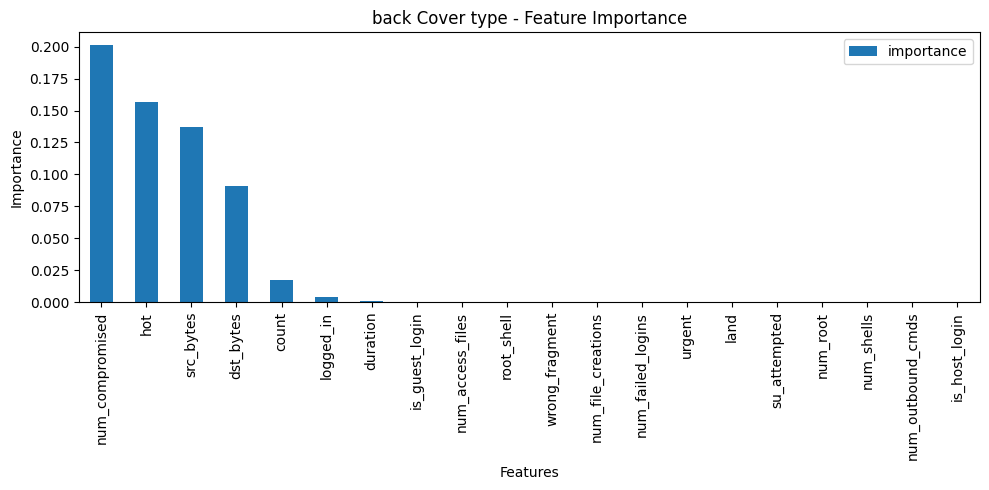

-----------------------------------------------------------------------------------------------




Processing CSV file: apache2.csv
apache2 importance list:
apache2 
                       importance
Features                        
dst_bytes           8.960096e-02
duration            5.848127e-02
src_bytes           3.695328e-02
count               3.677084e-02
logged_in           1.815960e-03
num_access_files    3.875258e-05
num_file_creations  1.219385e-05
hot                 1.219016e-06
root_shell          6.426242e-07
is_guest_login      8.626592e-08
num_root            4.282119e-08
wrong_fragment      2.890160e-11
num_compromised     8.944106e-12
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00 



apache2=["dst_bytes","duration","src_bytes","count","logged_in"]


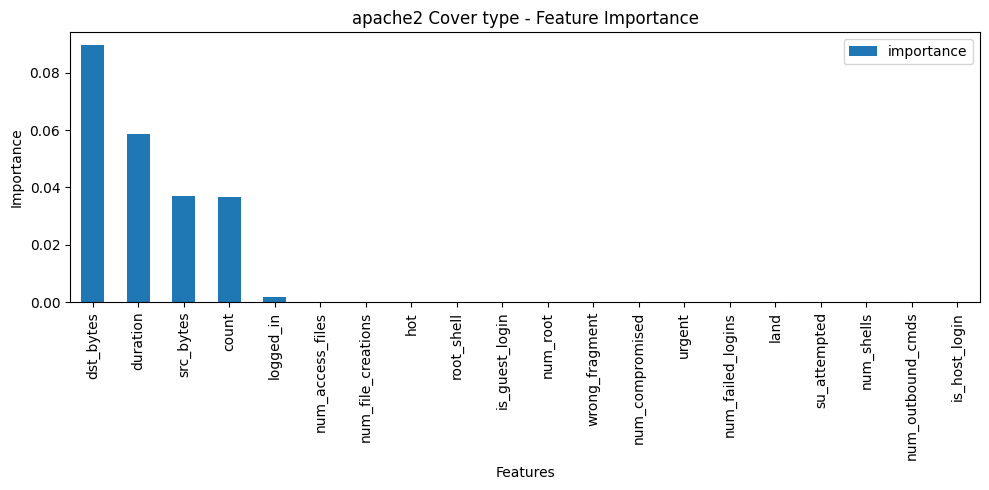

-----------------------------------------------------------------------------------------------




Processing CSV file: land.csv
land importance list:
land 
                     importance
Features                      
land                  0.106226
src_bytes             0.067803
dst_bytes             0.029084
count                 0.021341
logged_in             0.000983
duration              0.000055
hot                   0.000000
num_failed_logins     0.000000
urgent                0.000000
num_compromised       0.000000
wrong_fragment        0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



land=["land","src_bytes","dst_bytes","count","logged_in"]


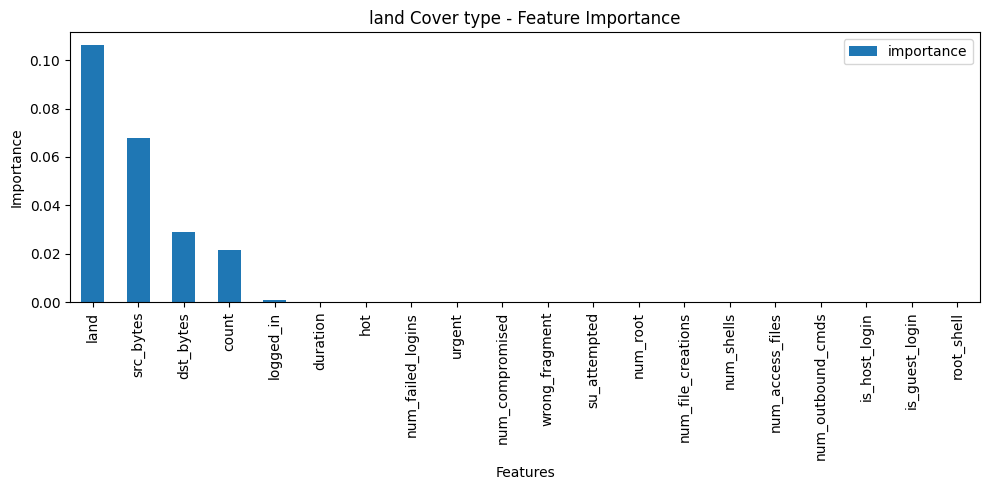

-----------------------------------------------------------------------------------------------




Processing CSV file: smurf.csv
smurf importance list:
smurf 
                       importance
Features                        
count               1.527202e-01
dst_bytes           9.265182e-02
src_bytes           6.664806e-02
logged_in           3.287462e-02
duration            1.296185e-03
wrong_fragment      4.839343e-05
hot                 2.276877e-05
num_compromised     3.416521e-07
num_access_files    1.986327e-10
urgent              0.000000e+00
num_failed_logins   0.000000e+00
land                0.000000e+00
su_attempted        0.000000e+00
num_root            0.000000e+00
num_file_creations  0.000000e+00
num_shells          0.000000e+00
num_outbound_cmds   0.000000e+00
is_host_login       0.000000e+00
is_guest_login      0.000000e+00
root_shell          0.000000e+00 



smurf=["count","dst_bytes","src_bytes","logged_in","duration"]


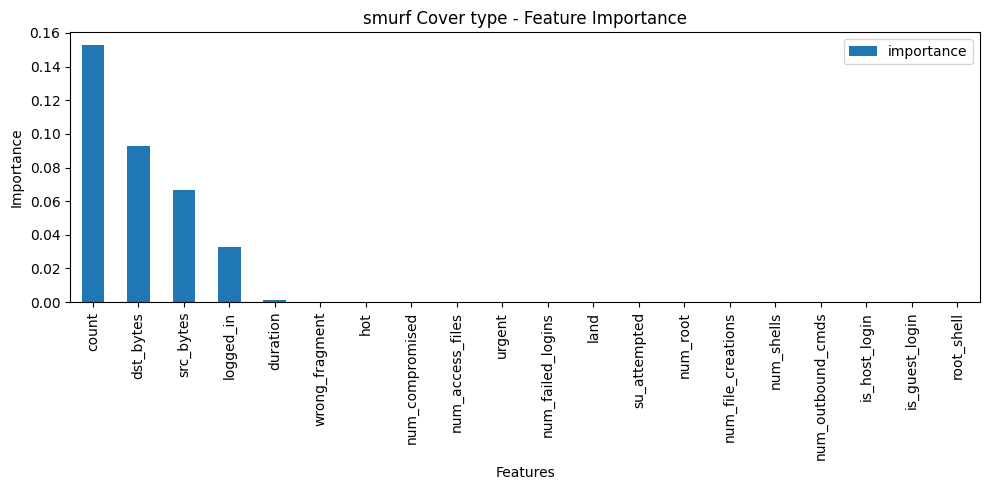

-----------------------------------------------------------------------------------------------




feature_importances: {'named': ['src_bytes', 'dst_bytes', 'duration', 'logged_in', 'count'], 'snmpgetattack': ['dst_bytes', 'src_bytes', 'count', 'logged_in', 'duration'], 'ipsweep': ['src_bytes', 'dst_bytes', 'count', 'logged_in', 'duration'], 'httptunnel': ['src_bytes', 'dst_bytes', 'count', 'logged_in', 'duration'], 'sendmail': ['src_bytes', 'duration', 'num_root', 'count', 'dst_bytes'], 'guess_passwd': ['duration', 'src_bytes', 'dst_bytes', 'count', 'num_failed_logins'], 'satan': ['count', 'src_bytes', 'dst_bytes', 'logged_in', 'duration'], 'ps': ['duration', 'num_file_creations', 'hot', 'src_bytes', 'count'], 'ftp_write': ['src_bytes', 'duration', 'urgent', 'dst_bytes', 'num_access_files'], 'xlock': ['duration', 'src_bytes', 'dst_bytes', 'count', 'num_compromised'], 'udpstorm': ['src_bytes', 'dst_bytes', 'count', 'logged_in', 'duration'], 'teardrop': ['wrong_fragment', 'src_bytes', 

In [18]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, svm, impor_bars in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [19]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [27 14 27 ... 27 27 14]
Total operation time: =  2.434644937515259 seconds


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/pyth

Best Tree's Decision Rules:
|--- flag_SF <= 0.50
|   |--- same_srv_rate <= 0.24
|   |   |--- dst_host_count <= 226.50
|   |   |   |--- same_srv_rate <= 0.19
|   |   |   |   |--- diff_srv_rate <= 0.31
|   |   |   |   |   |--- class: 14.0
|   |   |   |   |--- diff_srv_rate >  0.31
|   |   |   |   |   |--- dst_host_srv_count <= 1.50
|   |   |   |   |   |   |--- dst_host_same_src_port_rate <= 0.44
|   |   |   |   |   |   |   |--- service_private <= 0.50
|   |   |   |   |   |   |   |   |--- dst_host_diff_srv_rate <= 0.47
|   |   |   |   |   |   |   |   |   |--- class: 24.0
|   |   |   |   |   |   |   |   |--- dst_host_diff_srv_rate >  0.47
|   |   |   |   |   |   |   |   |   |--- class: 25.0
|   |   |   |   |   |   |   |--- service_private >  0.50
|   |   |   |   |   |   |   |   |--- class: 25.0
|   |   |   |   |   |   |--- dst_host_same_src_port_rate >  0.44
|   |   |   |   |   |   |   |--- class: 20.0
|   |   |   |   |   |--- dst_host_srv_count >  1.50
|   |   |   |   |   |   |--- dst_hos

[Text(0.5334881766585233, 0.9807692307692307, 'flag_SF <= 0.5\ngini = 0.648\nsamples = 157278\nvalue = [649, 851, 27, 5, 3431, 134, 1, 265, 11, 4, 4075\n863, 20, 11, 46528, 59, 48361, 0, 1, 81, 293, 646\n10, 10, 613, 1310, 9, 131177, 6197, 1877, 3, 12, 2\n1260, 1, 10, 6, 10]'),
 Text(0.14550124327311167, 0.9423076923076923, 'same_srv_rate <= 0.245\ngini = 0.145\nsamples = 31736\nvalue = [645, 33, 0, 0, 20, 118, 1, 0, 11, 0, 0, 758, 0\n2, 46528, 59, 141, 0, 1, 0, 293, 234, 0, 0, 500\n1002, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0]'),
 Text(0.031095341629828945, 0.9038461538461539, 'dst_host_count <= 226.5\ngini = 0.063\nsamples = 30202\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0\n46341, 0, 10, 0, 0, 0, 8, 0, 0, 0, 500, 1002\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.013069383048241399, 0.8653846153846154, 'same_srv_rate <= 0.185\ngini = 0.689\nsamples = 63\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0\n45, 0, 10, 0, 0, 0, 8, 0, 0, 0, 3, 12, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 

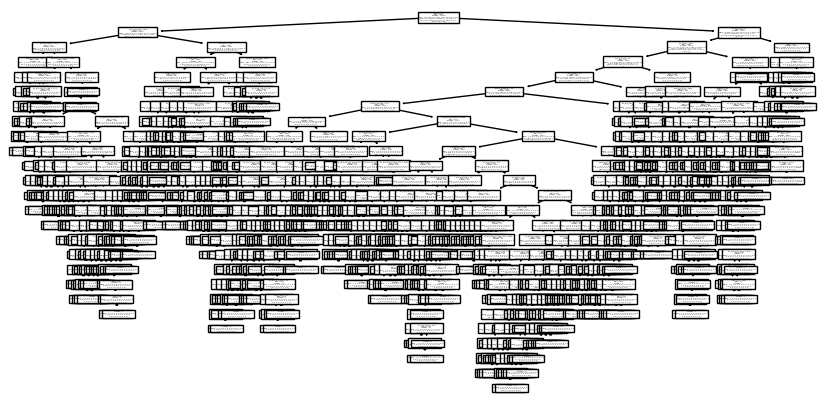

In [22]:
# Here we use out-of-bag score or use Gini Importance as criteria
best_tree_index = max(range(len(rf.estimators_)),
                      key=lambda i: rf.estimators_[i].score(X_train_df, y_train_df))
best_tree = rf.estimators_[best_tree_index]

feature_names = X_train_df.columns
tree_rules = export_text(best_tree, feature_names=feature_names)
print("Best Tree's Decision Rules:")
print(tree_rules)
plot_tree(best_tree, feature_names=feature_names)

# Step 4: Extract and print decision rules
# tree_rules = export_text(best_tree, feature_names=[f'feature_{i}' for i in range(X_train_df.shape[1])])
# print("Best Tree's Decision Rules:")
# print(tree_rules)

Multiclass Classification Evaluation


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


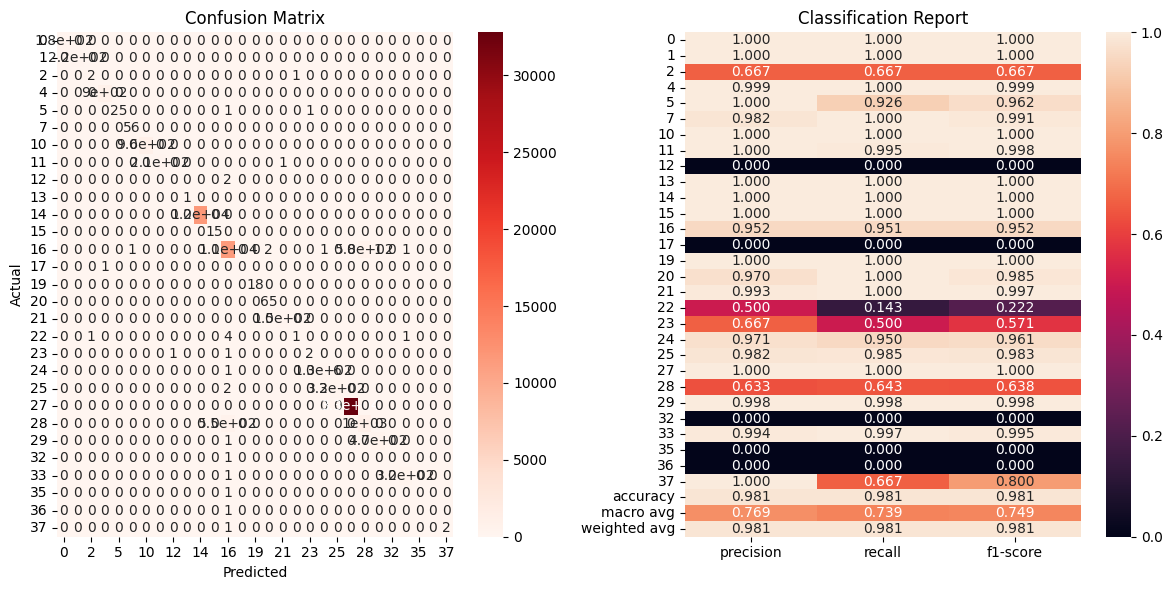

Accuracy: 0.9811915249332862


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.98119
f1-score_avg,0.98118
precision_avg,0.98119
recall_avg,0.98119


In [23]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [24]:
seconds = time.time()
CONF_THRESHOLD = 0.95
improve_cnt = 0
deprove_cnt = 0

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        max_prob = CONF_THRESHOLD
        final_class_1 = NORMAL_TARGET
        final_class_2 = final_class_1

        for key, knn in KNNs.items():
            sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
            if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                max_prob = sub_abnormal_class_prob
                final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'NORMAL improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'NORMAL deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if normal_class_prob > 1.0 - CONF_THRESHOLD and normal_class_prob < CONF_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
                    if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                        max_prob = sub_abnormal_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            # improve_cnt += 1
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            # deprove_cnt += 1
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        # knn_predictions.append((final_class_2, y_test_df.iloc[i]))

    return i, final_class_2

# Run all test data instances in parallel and retain order
knn_predictions = [None] * len(X_test_scaled_df)  # Pre-allocate an array for ordered predictions

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        knn_predictions[idx] = prediction  # Insert each prediction at its respective index

# print('improve_cnt', improve_cnt, 'deprove_cnt', deprove_cnt)
print("Total operation time: = ", time.time() - seconds, "seconds")

final_class1 16 final_class2 29 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 2 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 26 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 0 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 24 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 37 actual 16 NORMAL deprove [0.9665235]
final_class1 16 final_class2 26 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 13 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 7 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 26 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 3 actual 16 NORMAL deprove [0.98176012]
final_class1 16 final_class2 26 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 26 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 11 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 11 actual 16 NORMAL deprove [1.]
final_class1 16 final_class2 24 actual 16 NORMAL deprove [1

KNN Evaluation (overall)


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/

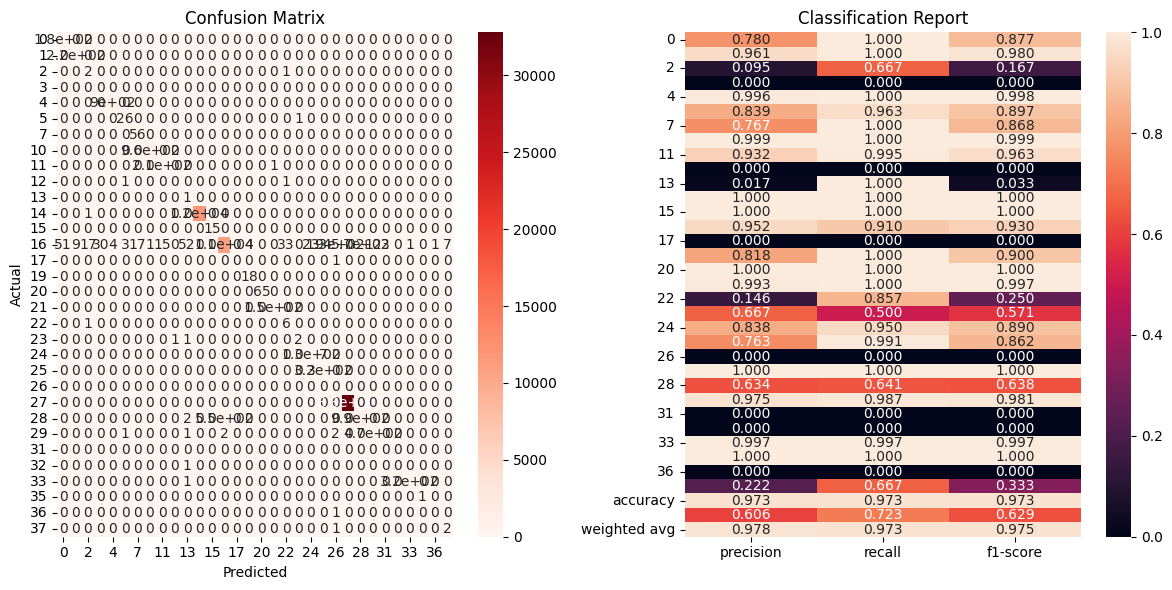

Accuracy: 0.9731858663151465


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.97319
f1-score_avg,0.97529
precision_avg,0.97798
recall_avg,0.97319


In [25]:
# Evaluate KNN on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final-fullsample-knn-conf0.95")

# Modify the list and extract the second element in one step
# final_knn_predictions = [t[0] for t in knn_predictions] # New
# final_knn_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in knn_predictions] # Old
final_knn_predictions_df = pd.DataFrame(knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()